# Project 11 : Mobility Hubs in 15 minutes

The **15-Minute City** is built upon the concept of “chrono-urbanism”, asserting that the quality of urban life is inversely related to the time spent on transportation, particularly using automobiles. Originating from the first author, Carlos Moreno, this concept advocates for urban environments where residents can easily reach all essential services within a **15-minute walk or bike ride**.

In the current "15-minute" framework, Moreno proposes that residents can experience an elevated quality of life by effectively fulfilling six essential urban social functions:

- Living,
- Working,
- Commerce,
- Healthcare,
- Education, and
- Entertainment. <br><br>

The concept revolves around four main dimensions:
- _Density_ (people per square kilometer)
- _Proximity_ (both spatial and temporal)
- _Diversity_
- _Digitalization_
<br> <br>


**Objective of the Project and Methodology** <br>
The main aim of the project is to propose a substantial deployment of mobility hubs in Louvain, focusing on maximizing coverage of the 15-minute accessibility measures. Here's a brief summary of the **Hybrid Deployment Strategy** deployed: 

- **Isochrone Analysis**: Create 15-minute bike isochrones from 2 different categories of starting points (single point Station and centroids of zones). Locate significant points within a 15-minute biking radius from the starting point and position a hub at each of these locations. Continue this process based on the newly established hubs. This approach ensures the presence of a mobility hub, potentially functioning as a bike-sharing point, every 15 minutes of cycling — a reasonable distance for bike coverage.

- **Optimal Placement Criteria**: the approach above alone is considered insufficient for a satisfactory deployment, as it overlooks demographic factors, traffic considerations, and the distance from the city center. Therefore, the proposed optimal placement strategy differentiates based on three stopping criteria:

1. Ensure an _"optimal" number of hubs in each Leuven zone_, where the optimal count (k) depends on demographic variables such as the number of commuters (in/out) per zone, the number of businesses in the area, and the number of cars owned by each household in the zone (different weights to these variables may be given by the policy makers).

2. Ensure that each hub in the central zone of Leuven has at least a _certain number of hubs within a 15-minute walking distance_. This decision facilitates convenient alternatives in case a hub lacks bikes or supports a multimodal transportation approach, allowing users to stop at one hub with one mode of transport and continue with another mode from a hub five minutes away on foot.

2. To avoid strategies favoring hub placement solely in the city center and resulting in segregation in the outskirts, the third strategy calls for inserting a minimum number of hubs in each "critical" peripheral zone. This is determined based on the _total outflow of cars_ from these areas during peak hours (8-9 AM), essentially creating a more extensive network for those typically commuting from the outskirts to the center.


## ISOCHRONE APPROACH (mapboxOSRM API): <br> _how far can we travel in 15 minutes?_

### Data exploration and few starting visualizations <br>
In this section, we proceed to display some maps with the aim of illustrating how the isochrone approach works in general and providing an idea of what it means spatially to travel 5, 10, 15 minutes by bike and on foot from the station in Leuven. It is important to note that Leuven is a medium-sized town with approximately 100,000 inhabitants 

In [1]:
import geopandas as gpd
import folium
from shapely.geometry import Polygon, Point
import pandas as pd
import numpy as np 
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [354]:
# qua sono presenti le zone socio demografiche di leuven ufficiali, ovvero quelle usate a fini statistici 
zone = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/leuven_statsec.gpkg')
zone = zone.to_crs('epsg:4326')

zone.head(3)

,UIDN,OIDN,CODSEC,NISCODE,SEC,SECNAAM,LENGTE,OPPERVL,STDEEL,geometry
0,19880,4074,24062A61-,24062,A61-,KAREELVELD,5896.98,1529378.12,LEUVEN NOORD,"MULTIPOLYGON (((4.68850 50.89458, 4.68895 50.8..."
1,20055,4078,24062B100,24062,B100,PUTKAPEL-CENTRUM,5277.17,980502.76,WILSELE WIJGMAAL,"MULTIPOLYGON (((4.72796 50.93378, 4.72742 50.9..."
2,20056,4087,24062B34-,24062,B34-,ROESELBERG,4205.81,643689.23,WILSELE WIJGMAAL,"MULTIPOLYGON (((4.69867 50.89670, 4.69866 50.8..."


In [353]:
# current mobility hubs in Lueven 
hubs = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/hub_data_leuven/mobility_hubs.gpkg', crs={'init':'epsg:31370'})
hubs = hubs.to_crs(epsg=4326)

To build isochrones, MapboxOSRM is utilized through an API as shown [here](https://docs.mapbox.com/playground/isochrone/).

the function below is used to extract all isochrones from points belonging to the gdf passed as a parameter. it allows specifying the time intervals of interest and the speed profile, which is, by default, set to "driving" but can also be set to "walking" or "cycling". at the end, the function returns a gdf  containing the geometries of the isochrones for each time interval 

In [389]:
from routingpy.routers import MapboxOSRM

MY_MAPBOXOSRM_API_KEY = 'pk.eyJ1IjoidnBpYyIsImEiOiJjbHI3aXQ5Mm0yOWlkMmpudnBtNHJ5OGx0In0.yXnhEOyVnjz6nriA4GK2-g'
mb = MapboxOSRM(api_key = MY_MAPBOXOSRM_API_KEY)

def get_isochrone(gdf, time, profile = "driving"):

    gdf['LON_VALUE'] = gdf.to_crs(4326).geometry.x
    gdf['LAT_VALUE'] = gdf.to_crs(4326).geometry.y

    coordinates = gdf[['LON_VALUE', 'LAT_VALUE']].values.tolist()

    isochrone_shapes = []

    if type(time) is not list:
        time = [time]

    time_seconds = [60 * x for x in time]

    # itero sulla lista di coordinate pairs e poi itero sull'oggetto ritornato per estrarre geom  
    for c in coordinates:
        iso_request = mb.isochrones(locations = c, profile = profile,
                                    intervals = time_seconds, polygons = "true")
        #print('iso request:', iso_request)
        for i in iso_request:
            iso_geom = Polygon(i.geometry[0])
            isochrone_shapes.append(iso_geom)

    df_values = gdf.drop(columns = ['geometry', 'LON_VALUE', 'LAT_VALUE'])

    time_col = time * len(df_values)

    # need to repeat the dataframe to account for multiple time intervals
    df_values_rep = pd.DataFrame(np.repeat(df_values.values, len(time_seconds), axis = 0))
    df_values_rep.columns = df_values.columns

    isochrone_gdf = gpd.GeoDataFrame(
        data = df_values_rep,
        geometry = isochrone_shapes,
        crs = 4326
    )

    isochrone_gdf['time'] = time_col

    # sorting the dataframe in descending order of time to improve visualization
    # (the smallest isochrones should go on top, which means they are plotted last)
    isochrone_gdf = isochrone_gdf.sort_values('time', ascending = False)

    return(isochrone_gdf)

In [3]:
# funzione per personalizzare le mappe folium 

def style(fill_color, border_color, spessore_contorno=2, opacita=0.5):
    return {
        'fillColor': fill_color,
        'color': border_color,
        'weight': spessore_contorno,
        'fillOpacity': opacita
    }

Now I create isochrones from the central station of Leuven (whose coordinates were taken from the epsg.io website) for time intervals of 5, 10, and 15 minutes on foot and by bicycle. Results are shown in the two maps below, put next to the other to enhance comparisons. 

In [363]:
stazione = (4.714594, 50.882175)    # recuperata da https://epsg.io
central_point_coords = zone.unary_union.centroid.x, zone.unary_union.centroid.y
central_point = Point(central_point_coords)


isocrone_walking = get_isochrone(gpd.GeoDataFrame(geometry=gpd.GeoSeries([Point(stazione)]), crs="EPSG:4326"), time = [5, 10,15], 
                            profile = "walking")

walk_map = folium.Map(location = (central_point_coords[1], central_point_coords[0]), zoom_start = 12.5) 
folium.GeoJson(isocrone_walking, style_function = lambda x: style('#6f00ff', 'black', spessore_contorno = 1, opacita = 0.4)).add_to(walk_map)
folium.Marker(
        location=[stazione[1], stazione[0]],
        icon=folium.Icon(color='darkpurple', icon = 'user') # icon può essere user or star or bell or flag
    ).add_to(walk_map)


isocrone_bike = get_isochrone(gpd.GeoDataFrame(geometry=gpd.GeoSeries([Point(stazione)]), crs="EPSG:4326"), time = [5, 10,15], 
                            profile = "cycling")

bike_map = folium.Map(location = (central_point_coords[1], central_point_coords[0]), zoom_start = 12.5) 
folium.GeoJson(isocrone_bike, style_function = lambda x: style('#6f00ff', 'black', spessore_contorno = 1, opacita = 0.4)).add_to(bike_map)
folium.Marker(
        location=[stazione[1], stazione[0]],
        icon=folium.Icon(color='darkpurple', icon = 'user') # icon = user or star or bell or flag
    ).add_to(bike_map)


In [364]:
from IPython.display import display, HTML

walk_map.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Walking isochrones starting from Leuven station</b></h3>
                                    """)
                                    )
bike_map.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Cycling isochrones starting from Leuven station</b></h3>
                                    """)
                                    )

display(HTML(f'<div style="display:flex">{walk_map._repr_html_()} {bike_map._repr_html_()}</div>'))

# a sinistra: partendo dall'icona centrale, dove arrivo camminando in 5, 10 e 15 minuti
# a destra: partendo dall'icona centrale, dove arrivo in bici in 5, 10 e 15 minuti

## Optimal placement algorithm 

In this section, I proceed with the implementation of the mobility hubs placement algorithm. The actual placement function, provided below, utilizes various auxiliary functions outlined immediately thereafter. 

As mentioned at the beginning of the notebook, the essential point of placement lies in 
1. constructing isochrones from the station/centroids of the zones and subsequently from the newly placed hubs, and 
2. differentiating among three stopping criteria that essentially aim to meet three distinct needs:

**First criterion**: The algorithm stops when in each zone there exists an "optimal" number k of hubs, determined based on the number of incoming and outgoing commuters in the zone, average number of cars owned per household, and the number of businesses in the area. Each variable has its weight, which can be adjusted according to requirements.

**Second criterion:** The algorithm stops when each hub in 'Leuven Centrum' has a specified number of hubs.

**Third criterion**: The algorithm stops when critical peripheral zones have a specified number of hubs. A zone is defined as critical based on its outflow traffic level during peak hours (8-9 AM).

Since the API call and isochrone construction are computationally intensive due to the explosion in the number of candidate points for computation, a relatively low max_iter value (between 5 and 15) is always set. Additionally, at each iteration, a pruning step is performed. The pruning aims to drastically reduce the number of candidate points for the subsequent isochrone construction. The pruning is designed such that, for a given hub candidate, all hubs within a certain pruning radius are removed.

### Helping functions 

In [ ]:
# funzione per il pruning, sia intermedio che finale
# la funzione prendere un gdf, l'id del punto da cui partire e un raggio 
# ritorna tutti i punti che si trovano ad una distanza < raggio dal current id e che verranno successivamente rimossi 

def pruning(gdf, current_id, radius):
    current_point = gdf.loc[gdf['ID'] == current_id, 'geometry'].iloc[0]
    neighbors = gdf.loc[gdf['geometry'].distance(current_point) < radius, 'ID'].tolist()
    neighbors.remove(current_id)  # per tenere current_id e non rimuoverlo 
    return neighbors

In [ ]:
# questa funzione viene usata quando l'algoritmo viene runnato con il terzo criterio di stop 
# si propone di identificare le zone critiche (intese come zone in cui outflow traffic è max) della città 
# a partire dal modello di traffico di leuven 

def retrieve_zone_critiche():
    
    traffico = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/traffic_data/traffic_model_leuven_baseline_2019.gpkg')
    traffico.drop_duplicates(subset='geometry_id', inplace=True)

    traffic_df= traffico[['from_node_id', 'to_node_id', 'flows_pae_aggr', 'flows_car_aggr']]
    traffic_df.rename(columns={'from_node_id':'origin', 'to_node_id': 'destination'}, inplace=True)

    # traffic tessellation 
    traffic_tess = traffico[['geometry_id', 'geometry']]
    traffic_tess.rename(columns={'geometry_id':'tile_ID'}, inplace=True)
    traffic_tess = gpd.GeoDataFrame(traffic_tess).to_crs('epsg:4326')
    traffic_tess.set_geometry(col=traffic_tess['geometry'])

    # restricting the traffic model data to socio dem areas only 
    traffic_df = traffic_df[traffic_df['origin'].isin(traffic_tess['tile_ID']) & traffic_df['destination'].isin(traffic_tess['tile_ID'])]

    # merge on tile_id 
    df_merged = pd.merge(left=traffic_df, right=traffic_tess, right_on='tile_ID', left_on='origin')

    gdf_merged = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")
    gdf_merged.set_geometry(col=gdf_merged['geometry'])

    gdf_zone = gpd.GeoDataFrame(zone, geometry='geometry', crs="EPSG:4326")
    gdf_zone = gdf_zone.rename(columns={'geometry': 'zone_geometry'})
    gdf_zone = gdf_zone.set_geometry(col=gdf_zone['zone_geometry'])

    # spatial join tra gdf_merged e le zone, inner perchè voglio solo le righe che matchano
    # il predicate dello sjoin è mantenuto di default a 'intersects' 
    result = gpd.sjoin(left_df=gdf_merged, right_df=gdf_zone, how='inner')
    gruppo = result.groupby(by=['index_right', 'zone_geometry', 'UIDN', 'SECNAAM', 'CODSEC']).agg({'flows_pae_aggr': 'sum', 'flows_car_aggr': 'sum'}).reset_index()

    gruppo = gruppo[['index_right','zone_geometry', 'UIDN','SECNAAM', 'CODSEC','flows_pae_aggr','flows_car_aggr']]
    gruppo.sort_values(by='flows_car_aggr', ascending=False)

    zone_critiche = gruppo.head(5) #oppure 10 
    
    return zone_critiche

In [ ]:
# conta hub all'interno di una zona 
def count_hubs_within_polygon(polygon, gdf):
    return gdf['geometry'].within(polygon).sum()

In [386]:
# funzione per assegnare il CODSEC a una punto passato come parametro 
# il CODSEC in Leuven è un identificativo univoco di tutte le zone socio dem  

def assign_CODSEC(point, zone_gdf):
    for _, row in zone_gdf.iterrows():
        if point.within(row['geometry']):  # posso fare anche uno spatial join sinistro, 'within' 
            return row['CODSEC']
    return None 

#def assign_CODSEC(point, zone_gdf):
    #joined_df = gpd.sjoin(gpd.GeoDataFrame(geometry=[point]), zone_gdf, how='left', op='within')
    #if not joined_df.empty:
     #   return joined_df.iloc[0]['CODSEC']
    #else:
     #   return None


This function below *retrieve_optimal_k* is used when the algorithm is run with the first stopping criterion,
i.e., when we are interested in terminating the execution only when each zone has its optimal number of hubs.
The function aims to find the optimal k for each zone based on some socio-demographic data from Leuven.

It takes the socio-demographic information dataframe and a series of weights.
The weights are currently arbitrary; ideally, they should be chosen to meet the needs of policy makers.

To determine k, consider the number of incoming/outgoing commuters in the zone,
the average number of cars owned by each household, and the number of businesses.

**What's the idea?** 
If there are many companies in a zone, then that area could be an "attrattore", 
and it's good to have more mobility hubs to prevent citizens from moving around by car.
The same principle applies to the number of cars.


In [214]:

def retrieve_optimal_k(socio_dem, w_commuters, w_cars, w_companies):
    optimal_k = {}  # {codsec della zona: valore ottimo di k}

    columns_to_normalize = ['inc_commuters', 'outg_commuters', 'average_nr_cars_hh', 'companies', 'total_65plus']

    scaler = MinMaxScaler()
    socio_dem[columns_to_normalize] = scaler.fit_transform(socio_dem[columns_to_normalize])

    socio_dem['opt_k'] = (w_commuters * (socio_dem['inc_commuters'] + socio_dem['outg_commuters'])+
                      w_cars * socio_dem['average_nr_cars_hh'] +
                      w_companies * socio_dem['companies']) #+ 1 / (w_pop65plus * socio_dem['total_65plus'])

    scaler = MinMaxScaler(feature_range=(1, 3))
    socio_dem['k_norm'] = scaler.fit_transform(socio_dem['opt_k'].values.reshape(-1, 1))

    #  droppo le righe di socio_dem che contengono nan nel codice 
    socio_dem = socio_dem.drop(socio_dem[socio_dem['CODSEC'].isna()].index)

    # creo dizionario con i valori normalizzati di k per ciascuna zona
    optimal_k = dict(zip(socio_dem['CODSEC'], (round(socio_dem['k_norm']))))

    return optimal_k


In [312]:
# due funzioni per facilitare creazione di mappe

import matplotlib.pyplot as plt

central_point_coords = zone.unary_union.centroid.x, zone.unary_union.centroid.y

def rgba2hex(rgba): # per i colori 
    return "#{:02x}{:02x}{:02x}".format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))

def visualize(punti, boundary_gdf, colore=False): # colore = True se vogliamo colorare gli hub in modo differente ad ogni iter --> per vedere come l'algo piazza i punti
    viz = folium.Map(location=(central_point_coords[1], central_point_coords[0]), zoom_start=12.5) 

    if colore: 
        num_colors = len(np.unique(punti['color']))
        colors = plt.cm.brg(np.linspace(0, 1, num_colors))
        color_mapping = {i + 1: colors[i] for i in range(num_colors)}
        punti['color_str'] = punti['color'].map(color_mapping)

    for _, row in punti.iterrows():
        geometry = row['geometry']

        if isinstance(geometry, Point):
            location = [geometry.y, geometry.x]
        else:
            location = [geometry[0].y, geometry[0].x]

        if colore:
            color_str = rgba2hex(row['color_str'])
            folium.CircleMarker(
                location=location,
                radius=3,
                color=color_str,
                fill=True,
                fill_color=color_str
            ).add_to(viz)

        else: 
            folium.CircleMarker(
                location=location,
                radius=3,
                color='purple',
                fill=True,
                fill_color='purple'
            ).add_to(viz)

    folium.GeoJson(boundary_gdf, style_function=lambda x: style('purple', 'purple', spessore_contorno=3, opacita=0.01)).add_to(viz)   

    return viz

### Placement
Placement is described above

In [450]:
def hub_placement(gdf_starting, socio_dem, max_iter, boundary, stopping, pruning_radius = 0.0015, profile='cycling', start = 'centroidi', colore=False):
    
    k = 1
    status = 'going'

    if start == 'stazione':
            station = (4.714594, 50.882175) 
            final_points = gpd.GeoDataFrame(geometry=gpd.GeoSeries([Point(station)]), crs="EPSG:4326")
            if colore:
                hubs_colori = []
                hubs_colori.append(gdf_starting.assign(color=k)) 
    else:
        final_points = gdf_starting.copy()
        if colore: 
            hubs_colori = []
            hubs_colori.append(gdf_starting.assign(color=k))
         
    while status != 'optimal':
        if k == 1: 
            isocrone = get_isochrone(gdf_starting, time=15, profile=profile) # retrieve isochronesx 
        else: 
            isocrone = get_isochrone(points_gdf_pruned, time=15, profile=profile) # retrieve isochronesx from the pruned df
        
        exterior_coords_list = []
        for _, row in isocrone.iterrows():
            exterior_coords = list(row['geometry'].exterior.coords)  # voglio i punti del perimetro esterno di ogni isocrona 
            exterior_coords_list.append(exterior_coords)

        filtered_exterior_coords_list = [] #tengo solo i punti che ricado all'interno della zona di interesse, chiamata boundary
        for exterior_coords in exterior_coords_list:
            filtered_exterior_coords = [coord for coord in exterior_coords if Point(coord).within(boundary)]
            filtered_exterior_coords_list.append(filtered_exterior_coords)

        flat_coordinates_list = [coord for sublist in filtered_exterior_coords_list for coord in sublist]
        points_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in flat_coordinates_list], crs="EPSG:4326") 
        
        ## PRUNING 
        points_gdf_pruned = points_gdf.copy()
        points_gdf_pruned['ID'] = range(len(points_gdf_pruned))
        indices_to_remove = []

        for current_id, row in points_gdf_pruned.iterrows():
            neighbors = pruning(points_gdf_pruned, current_id, pruning_radius)
            indices_to_remove.extend(neighbors)

        points_gdf_pruned = points_gdf_pruned.drop(indices_to_remove)

        final_points = pd.concat([final_points, points_gdf_pruned], ignore_index=True)
        
        if colore:
            hubs_colori.append(points_gdf_pruned.assign(color=k))
            hubs_colori_df = pd.concat(hubs_colori, ignore_index=True)

    
    # check condizioni di stop:
        
        # primo stopping criterion 
        if stopping == 'THR hub per zona':
            # IF ogni zona ha optimal k hubs THEN stop 
            codici_codsec = [assign_CODSEC(row['geometry'], zone) for _, row in final_points.iterrows()]
            final_points['CODSEC'] = codici_codsec
            optimal_k = retrieve_optimal_k(socio_dem, w_commuters=0.4, w_cars=0.25, w_companies=0.35)

            # check se ogni zona ha almeno un numero di hub pari a quello ritornato da retrieve_optimal_k
            optk_sorted = dict(sorted((str(k), v) for k, v in optimal_k.items()))
            optk_series = pd.Series(optk_sorted)
            grouped_size = final_points.groupby('CODSEC').size().reindex(optk_series.index)
            
            if all(grouped_size >= optk_series):
                    status = 'optimal' 
        
        # secondo stopping criterion 
        if stopping == '15-min walking':
          
            # IF ogni hub che ricade in una zona centrale ha almeno K hub a distanza < 15 min a piedi THEN stop 
            codici_codsec = [assign_CODSEC(row['geometry'], zone) for _, row in final_points.iterrows()]
            final_points['CODSEC'] = codici_codsec  # metto codice
            centro = zone[zone['STDEEL']== 'LEUVEN CENTRUM']  # mi restringo al centro 
            gdf_merged = pd.merge(final_points, centro, on='CODSEC', how='right')
            gdf_merged.rename(columns={'geometry_x':'geometry'}, inplace=True)
            gdf_merged = gpd.GeoDataFrame(gdf_merged, geometry=gdf_merged['geometry'], crs='epsg:4326')

            # isocrone A PIEDI a partire dagli hub centrali 
            iso = get_isochrone(gdf_merged, time=15, profile='walking')
            gdf_merged['within_isochrone'] = gdf_merged['geometry'].within(iso['geometry'].iloc[0])
            iso['numero_hubs'] = iso['geometry'].apply(lambda polygon: count_hubs_within_polygon(polygon, gdf_merged))

            if (iso['numero_hubs'] > 5).all(): 
                status = 'optimal' 
        
        if stopping == 'outflow traffic':
                
            # IF ogni zona ''critica'' ha almeno un hub THEN stop 
            # questo criterio di stop è pensato per evitare che le zone con più grande outflow, 
            # che sono tipicamente quelle più in periferia non siano servite da hub semplicemente perchè non centrali 
            # a seconda delle necessità è possibile pensare di aumentare il numero di hub minimi in ciascuna di queste zone
            # questo potrebbe aiutare a ridurre il numero di macchine in uscita che arrivano in centro 
                
                zone_critiche = retrieve_zone_critiche()
                zone_critiche['conteggio_hub'] = 0
                for index, row in zone_critiche.iterrows():
                    count = sum(final_points['geometry'].within(row['zone_geometry']))
                    zone_critiche.at[index, 'conteggio_hub'] = count

                if (zone_critiche['conteggio_hub'] >= 3).all():
                    status = 'optimal'

        # in ogni caso, se ho raggiunto il numero max di iterazioni oppure se non è specificato nessun criterio di stop --> END
        if k == max_iter:
             status = 'optimal'

        k+=1 

    ## PRUNING FINAL
    optimal_hubs = final_points.copy()
    optimal_hubs['ID'] = range(len(optimal_hubs))
    to_remove = []

    for current_id, row in optimal_hubs.iterrows():
        neighbors = pruning(optimal_hubs, current_id, 0.0025) # più aggressivo 0.004
        to_remove.extend(neighbors)

    optimal_hubs = optimal_hubs.drop(to_remove)

    if colore:  
        hubs_colori_df = hubs_colori_df.drop(to_remove)
        return final_points, optimal_hubs, hubs_colori_df, k
    return final_points, optimal_hubs, None, k


## Algorithm testing and Evaluation of the impact of stopping criteria 
In the following cells, the algorithm is tested with different stopping criteria. Initially, the isochrones are constructed only from the Leuven station, setting a maximum number of iterations. In the next cells, the first, second, and third criteria are tested under the same conditions, starting from the centroids of the zones. For each test, a map is provided, showing the final optimal arrangement of the hubs 


In [ ]:
# gdf con i centroidi delle zone socio demografiche di Leuven 
centroids = zone['geometry'].centroid
centroids_gdf = gpd.GeoDataFrame(geometry=centroids, crs=zone.crs)

# questo è il boundary che dElimita la zona di referenza dell'analisi di questo progetto
# rappresenta il perimetro più esterno delle zone socio demografiche di Leuven 
boundary = zone.unary_union
boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs="EPSG:4326")

# i dati socio demografici per zona
socio_dem_data = pd.read_excel('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/socio_demographic_data_leuven_2019.xlsx')


### Stopping criterion _max iter_ starting from Leuven station  

In [309]:
# mappa mobility hubs posizionati con l'algoritmo - a partire da un unico punto (stazione) - criterio stop max iter 
max_iter = 5 
prepruning, hubs_stazione, hubs_colori_stazione, k_stazione = hub_placement(centroids_gdf, socio_dem_data, boundary = boundary, max_iter = max_iter, stopping='none', start='stazione', colore = True)
mappa = visualize(hubs_colori_stazione, boundary_gdf, colore=True) 
mappa 
# colori diversi --> hub posizionati a iterazioni diverse

### First stopping criterion : _optimal k per zone_ 

In [351]:
# mappa dei mobility hubs posizionati con algoritmo a partire dai centroidi - primo stopping criterion 

max_iter = 15
prepruning_primo, hubs_primo, hubs_colori_primo, k_primo= hub_placement(centroids_gdf, socio_dem_data, boundary = boundary, max_iter = max_iter, stopping='THR hub per zona', start='centroidi')
mappa_primo = visualize(hubs_primo, boundary_gdf)
mappa_primo

### Second stopping criterion : _15 min walking_ 

In [342]:
# algoritmo con secondo stopping criterion a partire dai centroidi 

max_iter = 15 
prepruning_secondo, hubs_secondo, hubs_colori_secondo, k_secondo = hub_placement(centroids_gdf, socio_dem_data, boundary = boundary, max_iter = max_iter, stopping='15-min walking', start='centroidi')
mappa_secondo = visualize(hubs_secondo, boundary_gdf)
mappa_secondo

In [413]:
# salvo per usarlo dopo per la simulazone 
hubs_secondo.to_csv('hubs_optimal_secondo_stopping.csv', index=False)

### Third stopping criterion : _outflow traffic_

In [348]:
# algoritmo con terzo stopping  a partire dai centroidi 

max_iter = 15 
prepruning_terzo, hubs_terzo, hubs_colori_terzo, k_terzo = hub_placement(centroids_gdf, socio_dem_data, boundary = boundary, max_iter = max_iter, stopping='outflow traffic', start='centroidi')

mappa_terzo = visualize(hubs_terzo, boundary_gdf)
mappa_terzo


### Comparison between Placements Obtained through Different Stopping Criteria

In [377]:
from IPython.core.display import display, HTML


mappa_primo.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Primo criterio di stop</b></h3>
                                    """)
                                    )
mappa_secondo.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Secondo criterio di stop</b></h3>
                                    """)
                                    )
mappa_terzo.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Terzo criterio di stop</b></h3>
                                    """)
                                    )
mappa.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px"><b>Quarto criterio di stop</b></h3>
                                    """)
                                    )


display(HTML(f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="text-align:center; margin:10px;"><b>optimal k per zone </b></div>'
             f'<div style="text-align:center; margin:10px;"><b>15-minute walking</b></div>'
             '</div>'
             f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="margin:10px;">{mappa_primo._repr_html_()}</div>'
             f'<div style="margin:10px;">{mappa_secondo._repr_html_()}</div>'
             '</div>'
             f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="text-align:center; margin:10px;"><b>outflow traffic </b></div>'
             f'<div style="text-align:center; margin:10px;"><b>max iter from station</b></div>'
             '</div>'
             f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="margin:10px;">{mappa_terzo._repr_html_()}</div>'
             f'<div style="margin:10px;">{mappa._repr_html_()}</div>'
             '</div>'
))


**DISCUSSION ON PLACEMENT BASED ON STOPPING CRITERIA:** <br>
<br>
From the grid above with the four maps, we can essentially observe how the stopping criteria impact the placement. In the case of using the **first criterion** (which stops the algorithm only when each zone has optimal k hubs), neither the outer zones nor the center appear particularly disadvantaged. The central-eastern zone of Leuven remains uncovered by hubs. It is challenging to determine a priori whether this represents a disadvantage or not. Certainly, having a large disconnected area could lead to unintended segregation dynamics, which I believe could be interesting to evaluate in the future. On the other hand, this deployment could reflect a policy maker's intent expressed in the definition of weights for socio-demographic variables that influence the optimal number k of hubs.
<br>
<br>
The **second stopping criterion** (15-minute walking - I want hubs in Leuven center to have at least thr hubs within a 15-minute walk) inherently favors hub placement in central zones. To assess if there is an excessive hub density in the center, we would need to define the type of hubs involved (i.e., how many shared vehicles? What types? Other facilities?). If there are many shared vehicles, the density could be excessive leading to more congestion in the centre. However, if they are only bike exchange stations (e.g., cicloPi), it might make sense to avoid situations where, starting from the station, one arrives at Fibonacci and finds the rack full, and needs to cycle to the nearest one located, for example, at Carrefour in Pratale.
<br>
<br>
The **third stopping criterion**, the traffic-based one, leads to a more homogeneous hub placement, at least at first glance, not neglecting the ''critical'' zones, those with a significant outflow, and potentially encouraging commuters from these zones to switch to multimodal transport.
<br>
<br>
Finally, the configuration achieved by **starting only from the station** seems to be a hybrid between the first and third maps, essentially showing that starting from a set of nearly random points (the centroids) and starting from a single point leads to very similar results, with the disadvantage that starting with isochrone construction from a single point resulted in worse execution times.
<br>
<br>
This was a brief comparison of the results. In conclusion, I would say that future developments could consider creating an algorithm that allows **combining the above stopping criteria** without necessarily having to choose one


### Evaluation of the Pruning effect:
The final step of the placement algorithm involves executing a final pruning step.

_Why is the final pruning necessary if, at each iteration, the set of candidate points had already been pruned?_ <br>
<br> Because at each iteration pruning occurs only on the set of points found at that iteration and not previously ones, due to computational constraints. This means that, at the end of the algorithm, the found points may actually be very close to other points found in previous or subsequent iterations.
The final pruning is analogous to the intermediate pruning, using the same function: a candidate hub is considered, and all points within a distance <= pruning radius are removed. It is possible to change the final/intermediate pruning radus independently.

In [403]:
# con pruning finale più aggressivo r = 0.004 --> parto da un hub ed elimino tutti quelli che stanno in un intorno di 0.004 (valore in gradi)
prepruning_secondo_aggr, hubs_secondo_aggr, hubs_colori_secondo_aggr, k_secondo_aggr = hub_placement(centroids_gdf, socio_dem_data, boundary = boundary, max_iter = max_iter, stopping='15-min walking', start='centroidi')

In [381]:
mappa_secondo_aggr = visualize(hubs_secondo_aggr, boundary_gdf)
mappa_secondo_nopruning = visualize(prepruning_secondo_aggr, boundary_gdf)

The maps below depict the **impact of the final pruning** on the optimal arrangement of mobility hubs. It is crucial to note that this was carried out with the same intermediate pruning and other parameters. The arrangement without intermediate pruning is not displayed because 1. it is computationally impractical to retrieve isochrones for all points after a couple of iterations, and 2. the map would lose significance.

It is important to highlight how, for sufficiently high values of the final pruning radius (0.004 - on the right), the city center remains entirely uncovered by mobility hubs, while in the absence of final pruning (left), there is a significant overlap of points. The intermediate solution, on the other hand, demonstrates that a more appropriate radius value (0.0025) maintains the central hubs while simultaneously eliminating those that overlap

In [385]:
mappa_secondo_nopruning.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px; margin:0;"><b>Walking isochrones starting from Leuven station</b></h3>
                                    """)
                                    )
mappa_secondo.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px; margin:0;"><b>Cycling isochrones starting from Leuven station</b></h3>
                                    """)
                                    )
mappa_secondo_aggr.get_root().html.add_child(folium.Element("""
                                    <h3 align="center" style="font-size:16px; margin:0;"><b>Third map isochrones</b></h3>
                                    """)
                                    )

display(HTML(f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="text-align:center; margin:0; width:33%;"><b>Without final pruning</b></div>'
             f'<div style="text-align:center; margin:0; width:33%;"><b>With final pruning radius = 0.0025</b></div>'
             f'<div style="text-align:center; margin:0; width:33%;"><b>With final pruning radius = 0.4</b></div>'
             '</div>'
             f'<div style="display:flex; flex-wrap:wrap; justify-content:center;">'
             f'<div style="margin:0; width:33%;">{mappa_secondo_nopruning._repr_html_()}</div>'
             f'<div style="margin:0; width:33%;">{mappa_secondo._repr_html_()}</div>'
             f'<div style="margin:0; width:33%;">{mappa_secondo_aggr._repr_html_()}</div>'
             '</div>'
))

## Further Impovements 

### SUMO
It is believed to be interesting to observe how some metrics change in the simulations of two different scenarios:

1. **Base scenario**: vehicles move according to the traffic model of Leuven (still among the available data, [here](https://storageaccount11111111.blob.core.windows.net/container1/Leuven/traffic_data/traffic_model_leuven_baseline_2019.gpkg))

2. **Improved scenario**: vehicles still move on the same routes as the traffic model, but with some modifications:
   - It is assumed that only 10% of the existing flows are willing to change and switch to multimodal transport
   - The remaining 90% of flows remain unchanged, i.e., they continue to occur by carr 
   - The randomly selected 10%:
        - Starts from the current origin O
        - Drives by car to the nearest hub H1
        - Switches to a bicycle from H1 to the nearest hub to its destination (H2)
        - Walks from H2 to the destination D

Clearly, this scenario is heavily influenced by the estimation of the percentage of flows that will change their route. It also depends on the assumption of flow distribution as outlined above. However, it is assumed that flows during peak hours mostly involve incoming traffic to the city center for study/work reasons. In this perspective, once citizens reach H2, it is reasonable to assume that they continue for short distances on foot

Future developments of the project could consider the distances O-H1 and H2-D and the choice of the mode of transport based on these distances

#### creating a gdf for flows 

In [410]:
import numpy as np 
import pyogrio
import libsumo
import sys
import os 
from shapely.geometry import Point
from shapely.wkt import loads

In [420]:
df_hubs = pd.read_csv('hubs_optimal_secondo_stopping.csv')
# convert 'geometry' column from WKT to point 
df_hubs['geometry'] = df_hubs['geometry'].apply(loads)
gdf_hubs = gpd.GeoDataFrame(df_hubs, geometry='geometry', crs="EPSG:4326")

zone = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/leuven_statsec.gpkg')
traffico = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/traffic_data/traffic_model_leuven_baseline_2019.gpkg')
zone = zone.to_crs(epsg='4326')

In [ ]:
# dropping duplicates and renaming columns
traffico_filtrato = traffico.drop_duplicates(subset='geometry_id')
traffic_df= traffico_filtrato[['from_node_id', 'to_node_id', 'flows_pae_aggr', 'flows_car_aggr']]
traffic_df.rename(columns={'from_node_id':'origin', 'to_node_id': 'destination'}, inplace=True)

# creating a tessellation dataframe, that is a dataframe only containing geometry info
traffic_tess = traffico_filtrato[['geometry_id', 'geometry']]
traffic_tess.rename(columns={'geometry_id':'tile_ID'}, inplace=True)
traffic_tess = gpd.GeoDataFrame(traffic_tess).to_crs('epsg:4326')
traffic_tess.set_geometry(col=traffic_tess['geometry'])

# restricting the traffic model data to socio dem areas only 
origin_remove = []
for el in traffic_df['origin']:
    if el not in list(traffic_tess['tile_ID']):
       origin_remove.append(el)

destination_remove = []
for el in traffic_df['destination']:
    if el not in list(traffic_tess['tile_ID']):
       destination_remove.append(el)

traffic_df = traffic_df[~traffic_df['origin'].isin(origin_remove)]
traffic_df = traffic_df[~traffic_df['destination'].isin(destination_remove)]

In [ ]:
# voglio creare un gdf di flussi da usare nella simulazione gdf_flussi_summo, che contenga tutte le info necessarie
from sklearn.preprocessing import normalize

# per avere sia info traffico che sulle tess - sia ORIGINE che DESTINAZIONE 
df_merged = pd.merge(left=traffic_df, right=traffic_tess, right_on='tile_ID', left_on='origin') 
df_merged.rename(columns={'geometry':'geometry_origine', 'tile_ID':'tile_ID_origine'}, inplace=True)
df_merged_doppio = pd.merge(left=df_merged, right=traffic_tess, right_on='tile_ID', left_on='destination')
df_merged_doppio.rename(columns={'geometry':'geometry_destinazione', 'tile_ID':'tile_ID_destinazione'}, inplace=True)

#gdf del df sopra 
gdf_merged_doppio = gpd.GeoDataFrame(df_merged_doppio, geometry='geometry_origine', crs="EPSG:4326")
gdf_merged_doppio.set_geometry(col=gdf_merged_doppio['geometry_origine'])

gdf_zone = gpd.GeoDataFrame(zone, geometry='geometry', crs="EPSG:4326")
gdf_zone = gdf_zone.rename(columns={'geometry': 'zone_geometry'})
gdf_zone = gdf_zone.set_geometry(col=gdf_zone['zone_geometry'])

#join spaziale tra le zone di leuven e il mio gdf di flussi - voglio il CODSEC orig e dest 
result = gpd.sjoin(left_df=gdf_merged_doppio, right_df=gdf_zone, how='inner')
result.rename(columns={'zone_geometry':'zone_geometry_ORIG', 'UIDN':'UIDN_ORIG', 'CODSEC':'CODSEC_ORIG'}, inplace=True)
half = result.copy().drop(columns=['OIDN', 'NISCODE', 'SEC', 'SECNAAM', 'LENGTE', 'OPPERVL', 'STDEEL', 'index_right'])
half.set_geometry(col=half['geometry_destinazione'], inplace=True)

result = gpd.sjoin(left_df=half, right_df=gdf_zone, how='inner')
result.rename(columns={'zone_geometry':'zone_geometry_DEST', 'UIDN':'UIDN_DEST', 'CODSEC':'CODSEC_DEST'}, inplace=True)
other_half = result.copy().drop(columns=['OIDN', 'NISCODE', 'SEC', 'SECNAAM', 'LENGTE', 'OPPERVL', 'STDEEL', 'index_right'])


gdf_flussi_summo = other_half.copy().drop(columns=['tile_ID_origine', 'geometry_origine', 'tile_ID_destinazione', 'geometry_destinazione'])
gdf_flussi_summo = gdf_flussi_summo.reset_index(drop=True)

gdf_flussi_summo.to_csv('flussi_per_simulazione.csv', index=False)

columns_to_normalize = ['flows_pae_aggr', 'flows_car_aggr']
gdf_flussi_summo[['flows_pae_aggr_norm', 'flows_car_aggr_norm']] = normalize(gdf_flussi_summo[columns_to_normalize], axis=0, norm='l1', return_norm=False)
gdf_flussi_summo.head(2)

In [ ]:
# campiono i flussi, ogni flusso ha prob di essere scelto = flows_car_aggr_norm (fatto per evitare crash kernel)
k = 1000

# probabilities based on 'flows_car_aggr_norm'
probabilities = gdf_flussi_summo['flows_car_aggr_norm']

selected_records = gdf_flussi_summo.sample(n=k, replace=False, weights=probabilities, random_state=42)
selected_records.head(2)

In [ ]:
import sumolib
from shapely.geometry import LineString

# helping function to get a gdf from sumo road network (Giuliano Cornacchia)
# it has one column for the edge id and one column for the geometry
def gdf_from_sumo_network(sumo_road_network, crs="EPSG:4326", edge_list=None):
    edges_to_plot = sumo_road_network.getEdges()
        
    list_line_strings = []
    list_ids = [] 

    for edge in edges_to_plot: 
        list_ids.append(edge.getID())      
        edge_gps_list = [sumo_road_network.convertXY2LonLat(x[0], x[1]) for x in edge.getShape()]
        list_line_strings.append(LineString(edge_gps_list))

    df_net = gpd.GeoDataFrame(data = list_ids, geometry=list_line_strings, crs="EPSG:4326") 

    df_net.columns = ['id', 'geometry']
    return df_net 

#net = sumolib.net.readNet(r"C:\Users\Valeria\Documents\GitHub\geospatial_analytics\sumo_stuff\osm_proj11.net.xml")
net = sumolib.net.readNet(r"sumo_stuff\osm_proj11.net.xml")  
road_net = gdf_from_sumo_network(net)

In [ ]:
sampled_gdf = road_net.sample(n=2500, random_state=42) # altrimenti kernel crasha per prob memoria del mio pc 
sampled_gdf = sampled_gdf.set_geometry(col=sampled_gdf['geometry'])

selected_records = selected_records.set_geometry(col=selected_records['zone_geometry_ORIG'])
sampled_origine = sampled_gdf.sjoin(selected_records, predicate='within') #tutte le edge road ids delle zone di origine dei miei flussi 
sampled_origine.drop(columns=['index_right'], inplace=True) #altrimenti non va join 

In [ ]:
secondojoin_selected = selected_records[['zone_geometry_DEST','CODSEC_DEST']]
secondojoin_selected_gdf = gpd.GeoDataFrame(secondojoin_selected, geometry='zone_geometry_DEST', crs=sampled_origine.crs)

sampled_destinazione = sampled_gdf.sjoin(secondojoin_selected_gdf, predicate='within') # come sopra ma per la dest
sampled_destinazione.drop(columns=['index_right'], inplace=True)

In [ ]:
finale = sampled_origine.merge(sampled_destinazione, on='CODSEC_DEST', how='inner')
finale = finale.rename(columns={'id_x': 'id_ORIG', 'geometry_x': 'geom_road_ORIG','id_y':'id_DEST', 'geometry_y': 'geom_road_DEST'})
sampled_finale = finale.sample(n=1000, random_state=42)

#### creating .xml file for flows - *SCENARIO base* 

In [ ]:
## creazione del file del flussi - questo è per lo scenario base 
import xml.etree.ElementTree as ET
import random

root = ET.Element("routes")

for index, row in sampled_finale.iterrows():
    flow_element = ET.SubElement(root, "flow")
    flow_element.set("id", str(index))
    flow_element.set("from", str(row['id_ORIG']))
    flow_element.set("to", str(row['id_DEST']))
    flow_element.set("begin", "0")
    flow_element.set("end", "3600")
    flow_element.set("number", str(random.randint(0, 10)))  


tree = ET.ElementTree(root)
tree.write("flows.xml", encoding="utf-8", xml_declaration=True)

#### creating .xml file for flows - *SCENARIO DUE*

In [ ]:
# scenario due 
# questo codice per suddivisione del flusso e per scrivere relativo file dei flussi
# O --> H1 macchina
# H1 --> H2 bici 
# H2 --> D a piedi 

from shapely.ops import nearest_points

def find_nearest_hub(geom_strada, gdf_hubs): 
    # funzione che ritorna l'hub più vicino alla strada passata come param
    nearest_hub = gdf_hubs['geometry'].apply(lambda x: nearest_points(geom_strada, x))
    nearest_hub_distance = nearest_hub.apply(lambda x: geom_strada.distance(x[1]))
    indice_hub_piu_vicino = nearest_hub_distance.idxmin()
    hub_piu_vicino = gdf_hubs.iloc[indice_hub_piu_vicino]['geometry']
    return hub_piu_vicino

def convert_to_sumo_coordinates(lon, lat, net):
    x, y = net.convertLonLat2XY(lon, lat)
    return x, y


tot = len(sampled_finale)
perc = 0.10
num_da_sel= int(perc * tot)
record_selezionati = sampled_finale.sample(n=num_da_sel)

root = ET.Element("routes")
veh_element = ET.SubElement(root, 'vType')
# <vType id="type1" accel="1" decel="2" maxSpeed="20"/>
veh_element.set("id", 'bici')
veh_element.set("accel", "1")
veh_element.set("decel", "2")
veh_element.set("maxSpeed", "20")
veh_element.set("emissionClass","Zero")

veh_element = ET.SubElement(root, 'vType')
veh_element.set("id", 'pedone')
veh_element.set("accel", "1")
veh_element.set("decel", "2")
veh_element.set("maxSpeed", "7")
veh_element.set("emissionClass","Zero")


for _, record_strada in record_selezionati.iterrows():
    # origine O
    geom_strada_orig = record_strada['geom_road_ORIG']
    hub_piu_vicino_orig = find_nearest_hub(geom_strada_orig, gdf_hubs)
    x_hub_orig, y_hub_orig = convert_to_sumo_coordinates(hub_piu_vicino_orig.x, hub_piu_vicino_orig.y, net)

    # destinazione D
    geom_strada_dest = record_strada['geom_road_DEST']
    hub_piu_vicino_dest = find_nearest_hub(geom_strada_dest, gdf_hubs)
    x_hub_dest, y_hub_dest = convert_to_sumo_coordinates(hub_piu_vicino_dest.x, hub_piu_vicino_dest.y, net)

    # cerco strade più vicino agli hub 
    candidates_edges_orig = net.getNeighboringEdges(x_hub_orig, y_hub_orig, r=25)
    candidates_edges_dest = net.getNeighboringEdges(x_hub_dest, y_hub_dest, r=25)
    try:
        closest_edge_hub_dest = sorted(candidates_edges_dest, key=lambda x: x[1])[0][0]
        closest_edge_hub_orig = sorted(candidates_edges_orig, key=lambda x: x[1])[0][0]
    except:
        continue

    # flusso tra O e H1
    flow_element = ET.SubElement(root, "flow")
    flow_element.set("id", str(record_strada.name))
    flow_element.set("from", str(record_strada['id_ORIG']))
    flow_element.set("to", str(closest_edge_hub_orig.getID()))
    flow_element.set("begin", "0")
    flow_element.set("end", "3600")
    flow_element.set("number", str(random.randint(0, 10)))

    # flusso tra H1 e H2
    flow_element = ET.SubElement(root, "flow")
    flow_element.set("id", str(record_strada.name)+'sub')
    flow_element.set("from", str(closest_edge_hub_orig.getID()))
    flow_element.set("to", str(closest_edge_hub_dest.getID()))
    flow_element.set("begin", "0")
    flow_element.set("end", "3600")
    flow_element.set("type", "bici")
    flow_element.set("number", str(random.randint(0, 10)))

    # flusso tra H2 e destinazione D
    flow_element = ET.SubElement(root, "flow")
    flow_element.set("id", str(record_strada.name)+'sub2')
    flow_element.set("from", str(closest_edge_hub_dest.getID()))
    flow_element.set("to", str(record_strada['id_DEST']))
    flow_element.set("begin", "0")
    flow_element.set("end", "3600")
    flow_element.set("type", "pedone")
    flow_element.set("number", str(random.randint(0, 10)))


for _, record_strada in sampled_finale.iterrows():
    if record_strada.name not in record_selezionati.index:
        flow_element = ET.SubElement(root, "flow")
        flow_element.set("id", str(record_strada.name))
        flow_element.set("from", str(record_strada['id_ORIG']))
        flow_element.set("to", str(record_strada['id_DEST']))
        flow_element.set("begin", "0")
        flow_element.set("end", "3600")
        flow_element.set("number", str(random.randint(0, 10)))


tree = ET.ElementTree(root)
tree.write("flussi_segmentati.xml", encoding="utf-8", xml_declaration=True)


#### creating a traffic demand using Duarouter - both for scenario base and scenario due

In [ ]:
'''
duarouter non funziona correttamente se runno il codice così : 

command_str_astar = "duarouter --route-files flows.xml "+\
        " --net-file osm_proj11.net.xml"+\
        " --output-file traffic_demand_proj11.rou.xml --routing-algorithm astar"

p = subprocess.Popen(command_str_astar, shell=True, stdout=subprocess.PIPE, 
                                     stderr=subprocess.STDOUT)
retval = p.wait()'''


In [401]:
# creazione della domanda di traffico DA TERMINALE  

# PER LO SCENARIO BASE : 
# duarouter --route-files flows.xml --net-file osm_proj11.net.xml --output-file traffic_demand_proj11.rou.xml --routing-algorithm astar --repair true --repair.to true --repair.from true

# PER LO SCENARIO DUE : 
# duarouter --route-files flussi_segmentati.xml --net-file osm_proj11.net.xml --output-file traffic_demand_proj11_segmentati.rou.xml --routing-algorithm astar --repair true --repair.to true --repair.from true

#### simulating scenario base 

In [426]:
# creo comando per usare sumo - scenario BASE 
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

sumo_binary = os.environ['SUMO_HOME']+"bin\sumo"  
sumo_cmd = [sumo_binary, "-c", os.getcwd()+'\sumo_stuff\osm_proj11.sumocfg']

In [425]:
# SIMULAZIONE scenario base 
avg_time = []
co2_avg = []


for i in range(15): # più simulazioni per trovare tempi medi 
    libsumo.start(sumo_cmd)

    time_dict = dict()
    co2_emissions = dict()

    # finchè non ci sono più veicoli 
    while libsumo.simulation_getTime() < 1000 or len(libsumo.vehicle.getIDList()) > 0 :
        libsumo.simulationStep()

        #per ogni veicolo prendo l'ultimo travel time, normalizzo i tempi per la distanza percorsa 
        for v in libsumo.vehicle.getIDList():
            distance = libsumo.vehicle.getDistance(v)
            time = libsumo.simulation_getTime()
            co2 = libsumo.vehicle.getCO2Emission(v)

            if distance == 0:
                distance = 1 # zero div err

            timebydist = time/distance
            time_dict[v] = timebydist
            co2_emissions[v] = co2

    avg_co2 = np.mean(list(co2_emissions.values()))
    co2_avg.append(avg_co2)


    avg_time.append(np.mean(list(time_dict.values()))/60)


libsumo.close()


In [427]:
print("average time scenario base:", np.mean(avg_time))  # 0.0019426762
print("average CO2 emission scenario base:", np.mean(co2_avg))  # 3111.71747960733

average time scenario base: 0.0019420576352594315
average CO2 emission scenario base: 3111.7174796073355


#### simulating scenario due

In [ ]:
# creo comando per usare sumo - scenario DUE 
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

sumo_binary = os.environ['SUMO_HOME']+"bin\sumo"  
sumo_cmd = [sumo_binary, "-c", os.getcwd()+'\sumo_stuff\osm_proj11_segmentati.sumocfg']

In [ ]:
# SIMULAZIONE scenario 10% flussi vengono segmentati come spiegato sopra
# O --> H1 macchina
# H1 --> H2 bici 
# H2 --> D a piedi
 
avg_time_seg = []
co2_avg_seg = []


for i in range(15): # più simulazioni per trovare tempi medi 
    libsumo.start(sumo_cmd)

    time_dict = dict()
    co2_emissions = dict()

    # finchè non ci sono più veicoli 
    while libsumo.simulation_getTime() < 1000 or len(libsumo.vehicle.getIDList()) > 0 :
        libsumo.simulationStep()

        #per ogni veicolo prendo l'ultimo travel time, normalizzo i tempi per la distanza percorsa 
        for v in libsumo.vehicle.getIDList():
            distance = libsumo.vehicle.getDistance(v)
            time = libsumo.simulation_getTime()
            co2 = libsumo.vehicle.getCO2Emission(v)

            if distance == 0:
                distance = 1 # zero div err

            timebydist = time/distance
            time_dict[v] = timebydist
            co2_emissions[v] = co2

    avg_co2 = np.mean(list(co2_emissions.values()))
    co2_avg_seg.append(avg_co2)


    avg_time_seg.append(np.mean(list(time_dict.values()))/60)


libsumo.close()

In [ ]:
print("average time scenario due:", np.mean(avg_time_seg)) # 0.002353613712
print("average CO2 emission scenario due:", np.mean(co2_avg_seg))  # 2509.86980214854

the simulation draft above shows a **significant reduction in CO2**, assuming that only 10% of commuters are willing to engage in multimodal transportation

In [ ]:
reduction_perc = (co2_avg - co2_avg_seg) / co2_avg * 100 
print('riduzione percentuale di emissioni di co2:', reduction_perc, '%')

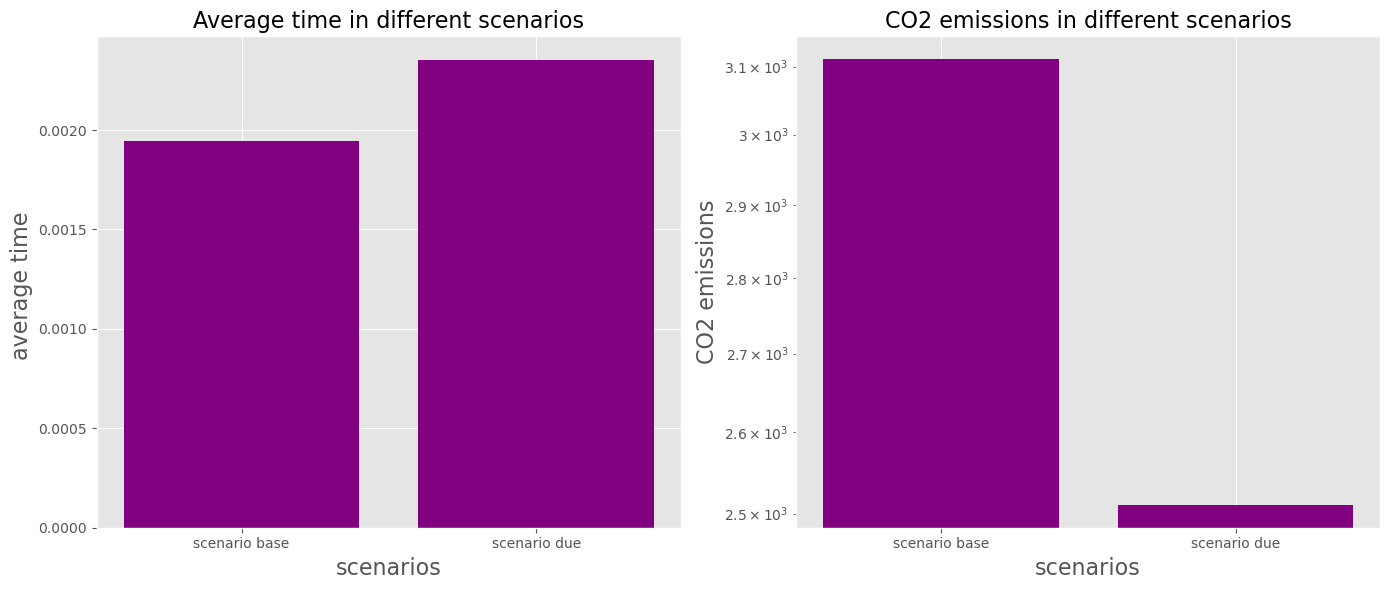

In [458]:
# this is a plot to show how avg time & CO2 emissions change 
# assuming 10% of commuters choose multimodal transport with optimal hubs 

# nb i tempi sono normalizzati per la distanza percorsa dal veicolo 
scenarios = ['scenario base', 'scenario due']
avg_time = [np.mean(avg_time), np.mean(avg_time_seg)]
co2_avg = [np.mean(co2_avg), np.mean(co2_avg_seg)]

avg_time = [avg_time, avg_time_seg]
co2_avg = [co2_avg, co2_avg_seg]

plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# avg tempo 
axs[0].bar(scenarios, avg_time, color='purple')
axs[0].set_xlabel('scenarios', fontsize=16)
axs[0].set_ylabel('average time ', fontsize=16)
axs[0].set_title('Average time in different scenarios', fontsize=16)

# co2 con scala log 
axs[1].bar(scenarios, co2_avg, color='purple')
axs[1].set_xlabel('scenarios', fontsize=16)
axs[1].set_ylabel('CO2 emissions', fontsize=16)
axs[1].set_title('CO2 emissions in different scenarios', fontsize=16)
axs[1].set_yscale('log')  

plt.tight_layout()
plt.show()

### Potential further development: **POIs**
instead of starting from centroids, we could have started from the nearest road to the POIs. identification of POIs could be done through the Google Places API. 

*why POIs?* <br>
starting from the nearest road to POIs allows for better alignment with actual user behavior and preferences. commuters are typically interested in reaching specific destinations or POIs rather than generic centroid locations. By optimizing mobility hubs based on the proximity to popular destinations, the service becomes more user-centric, increasing overall accessibility.